# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise Directions

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('/Users/jacobschroeder/anaconda3/projects/hospital_readmit/data/cms_hospital_readmissions.csv')

****
## Preliminary Analysis

In [4]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')

/Users/jacobschroeder/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


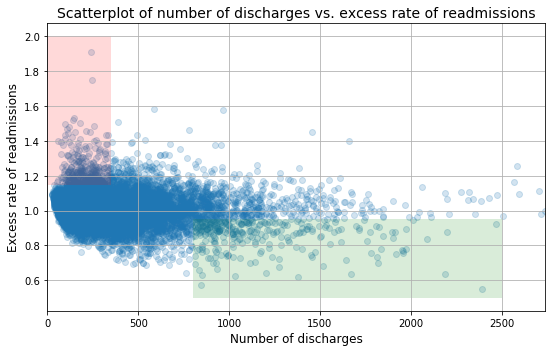

In [5]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 


**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 


**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.


**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.


****
### Exercise

Include your work on the following **in this notebook and submit to your Github account**. 

A. Do you agree with the above analysis and recommendations? Why or why not?
   
B. Provide support for your arguments and your own recommendations with a statistically sound analysis:

   1. Setup an appropriate hypothesis test.
   2. Compute and report the observed significance value (or p-value).
   3. Report statistical significance for $\alpha$ = .01. 
   4. Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?
   5. Look at the scatterplot above. 
      - What are the advantages and disadvantages of using this plot to convey information?
      - Construct another plot that conveys the same information in a more direct manner.


You can compose in notebook cells using Markdown: 
+ In the control panel at the top, choose Cell > Cell Type > Markdown
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

### A. Do you agree with the above analysis and recommendations? Why or why not?

No, conclusion is unfounded without the proper analysis and the summary statistics used are misleading. The conclusion is unfounded because it does not factor in linear regression and random resampling. The summary statistics are misleading because they do not include a p-value and do not take into account measures of dispersion.

A linear regression analysis and a two-sample t-test will help determine if the proposed conclusion and analysis are valid.

---------------------------

### B1.

#### My Own Statistical Analysis: Linear Regression with Hacker Statistics

In [38]:
del clean_hospital_read_df['Footnote']
df = clean_hospital_read_df.dropna()
df.to_csv('/Users/jacobschroeder/anaconda3/projects/hospital_readmit/data/cms_hospital_readmissions_test.csv')

(11578, 11)
(11497, 11)


In [52]:
# variables to hold the data, with clean index for each
num_discharges = df['Number of Discharges'].reset_index()
num_discharges = num_discharges['Number of Discharges']
read_ratio = df['Excess Readmission Ratio'].reset_index()
read_ratio = read_ratio['Excess Readmission Ratio']

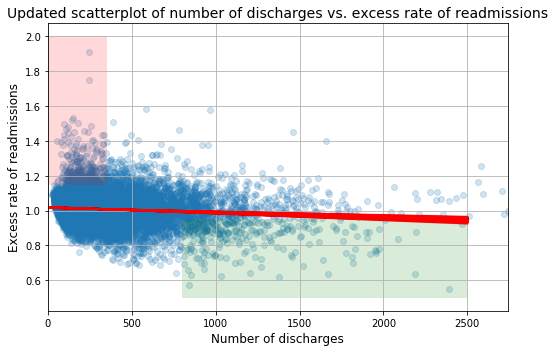

In [55]:
# bootstrap replicate functions
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap data of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)


def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

# linear regression function
def draw_bs_linear_reg(x, y, size=1):
    
    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        # print(x[bs_inds], y[bs_inds])
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(x[bs_inds], y[bs_inds], deg=1)
        # print(bs_slope_reps[i], bs_intercept_reps[i])
    return bs_slope_reps, bs_intercept_reps
        

# create replicates
read_replicates_slope, read_replicates_intercept = draw_bs_linear_reg(num_discharges, read_ratio, 1000)

# plot original scatterplot
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Updated scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()


# Plot the bootstrap lines
for i in range(1000):
    plt.plot(a, (a * read_replicates_slope[i]) + read_replicates_intercept[i],
             color='red', alpha=0.2)

plt.show()

#### Linear Regression Findings:

The linear regression shows that the relationship between discharges and beds is not as extreme as we might have initially thought. This supports critique of the original analysis being unfounded or misleading.

Note the slight increase in dispersion as discharges increase - this may infer that in certain scenarios, the trend is not strong, or even reversed.

-------------------

#### My Own Statistical Analysis: Two-Sample T-Test

Null hypothesis: an increase in discharges results in an increase in the excess rate of admissions.

Alternate hypothesis: the increase is not statistically significant

In [61]:
# Test Null Hypothesis: two-sample t-test on the different groups described above

# In hospitals/facilities with number of discharges < 100
    # mean excess readmission rate is 1.023
    # 63% have excess readmission rate greater than 1
# In hospitals/facilities with number of discharges > 1000
    # mean excess readmission rate is 0.978
    # 44% have excess readmission rate greater than 1
    
less_than_100 = df[['Number of Discharges', 'Excess Readmission Ratio']][df['Number of Discharges'] < 100]
greater_than_1000 = df[['Number of Discharges', 'Excess Readmission Ratio']][df['Number of Discharges'] > 1000]

num_lt_100, _ = less_than_100.shape
num_gt_1000, _ = greater_than_1000.shape

print("""
        ======================================================
        There are {} entries with less than 100 discharges
        
        There are {} entries with greater than 1000 discharges
        ======================================================
""".format(num_lt_100, num_gt_1000))


        There are 1188 entries with less than 100 discharges
        
        There are 463 entries with greater than 1000 discharges



In [90]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

# run the two-sample test
lt_100_replicates = draw_bs_reps(less_than_100['Excess Readmission Ratio'], np.mean, size=10000)
gt_1000_replicates = draw_bs_reps(greater_than_1000['Excess Readmission Ratio'], np.mean, size=10000)

# do hospitals with greater than 1000 discharges have fewer readmissions?
print("""
        Less Than 100 Mean Readmission Ratio: {}
                Confidence Interval: {}
        Greater Than 1000 Mean Readmission Ratio: {}
                Condidence Interval: {}
        P-Value: {}

""".format(np.mean(lt_100_replicates),np.percentile(lt_100_replicates, [0.5, 99.5]),np.mean(gt_1000_replicates),np.percentile(gt_1000_replicates, [0.5, 99.5]),(sum(gt_1000_replicates >= np.mean(lt_100_replicates))/len(gt_1000_replicates))))


        Less Than 100 Mean Readmission Ratio: 1.0225975276430979
                Confidence Interval: [ 1.01828838  1.02714058]
        Greater Than 1000 Mean Readmission Ratio: 0.9783918538444925
                Condidence Interval: [ 0.96348885  0.99244071]
        P-Value: 0.0




### B2-B3

When computing whether hospitals with greater than 1000 discharges see significantly fewer readmissions than hospitals with fewer than 100 discharges, the resulting P-Value is less than 0.01. This indicates a statistically strong relationship.

This p-value was computed at the 99% confidence interval - satisfying the requirement that the statistical significance be computed at 1% standard error.

-------------

### B4. Statistical vs. Practical Significance

Though the statistics show a strong statistical significance for our findings, the findings themselves do not enable practical action. Therein lies the difference between statistical and practical significance.

In this example, our two-sample t-test proved that larger operations have less readmissions than smaller operations. Yet, we are stuck with the question as to why?

It will be difficult to recommend any precise action based off this data, since there are many smaller hospitals who are performing well and there are a few mid-size and larger hospitals who are not performing well (in terms of readmission rate). Therefore, the recommendation to the client - to closely monitor smaller hospitals for quality of care - does not resolve the true, underlying issue. It is a mere blanketed resolution that will waste resources.

---------------------

### B5. Advantages and Disadvantages of Current Plot

##### Advantages:
The advantage of the current plot is that is shows all of the data points. With transparency enabled, we are easily able to tell where densities occur (namely, middle-left). We can also tell, loosely, the differences in dispersion as discharges increase (that there are fewer large hospitals and their readmission rates appear spread apart).

##### Disadvantages:
The disadvantage of this plot is that it does not illustrate the relationship in a concise and clear manner. The shaded areas show interesting phenomena, but do not give us a precise understanding of why the data is appearing the way it is appearing. 

For example, we notice there is a rise of readmissions for smaller hospital operations, but we are not sure what is causing the rise. Perhaps it has to do with poor hospital funding in sparsely populated states? 

Regardless, since there are so many smaller hospitals with satisfactory performance, the rise is difficult to understand or isolate from a causation perspective.

### B5. An Improved Plot For More Precise Recommendations

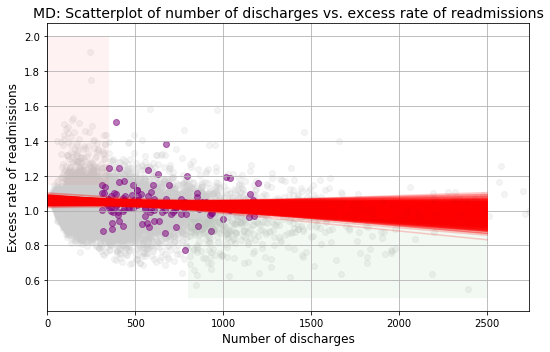

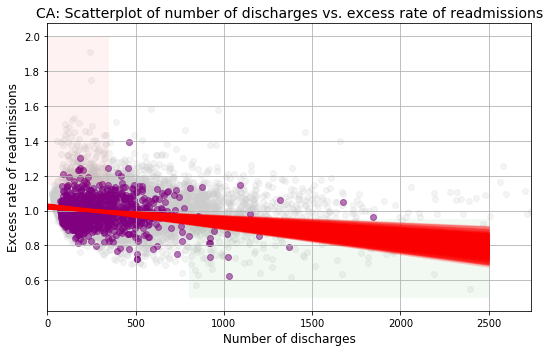

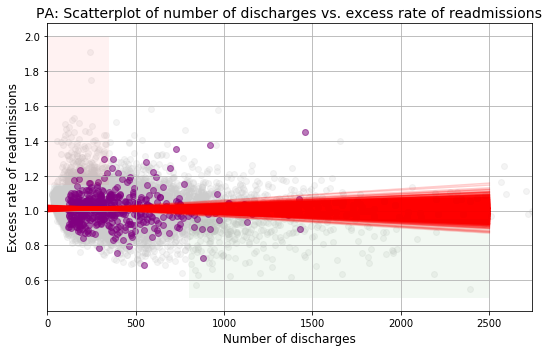

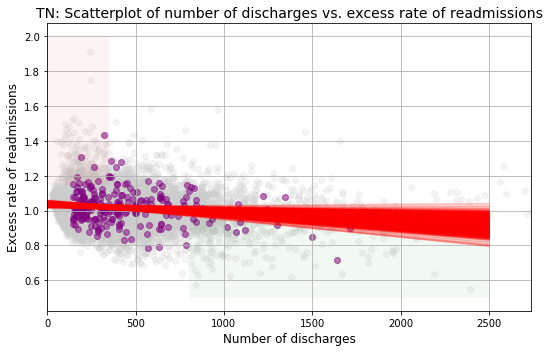

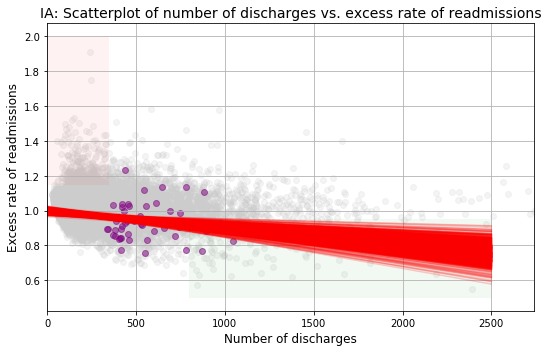

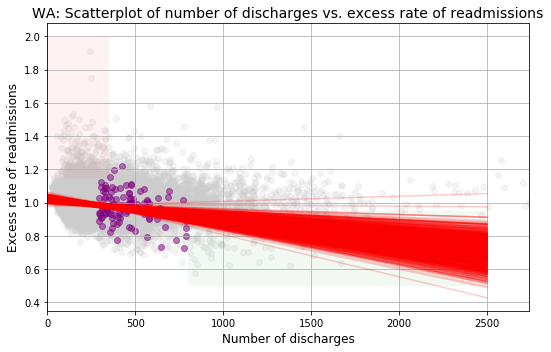

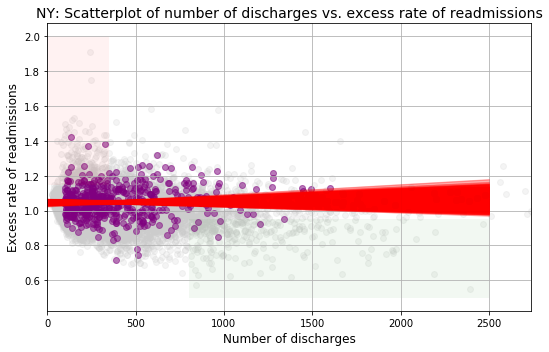

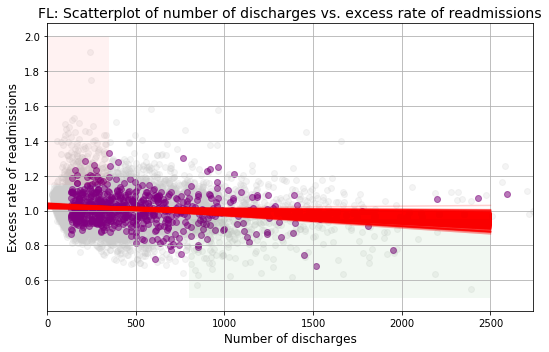

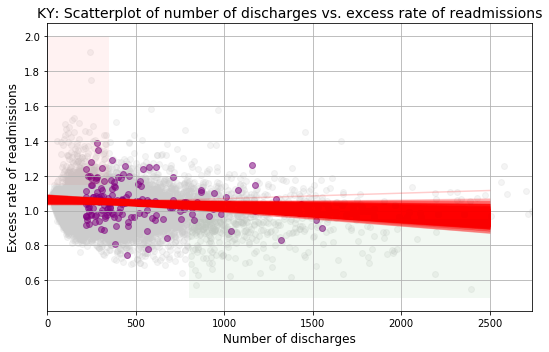

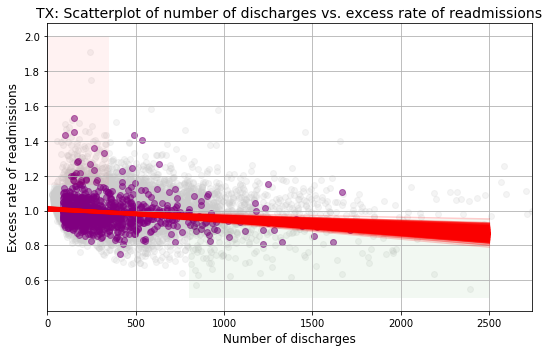

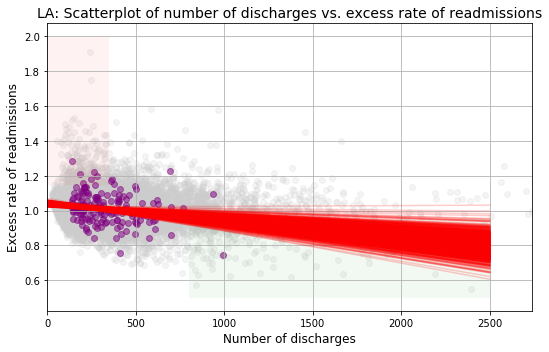

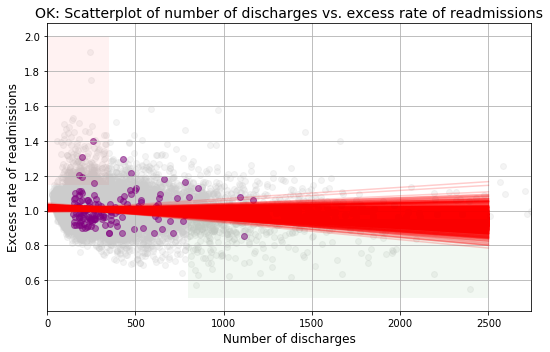

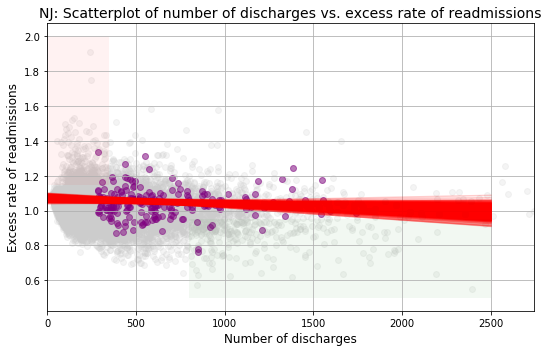

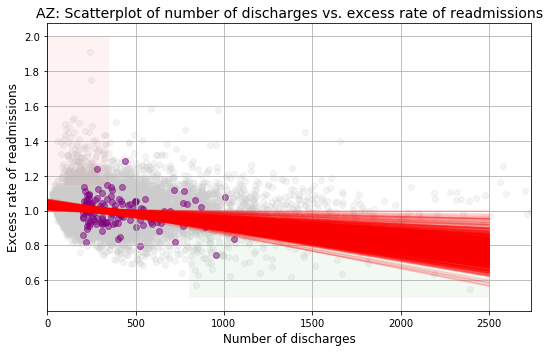

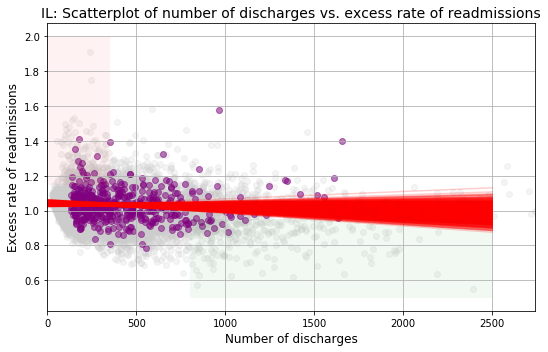

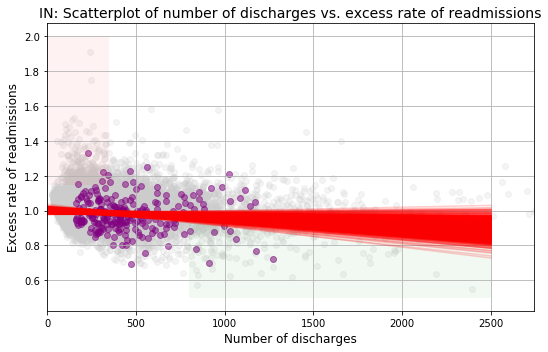

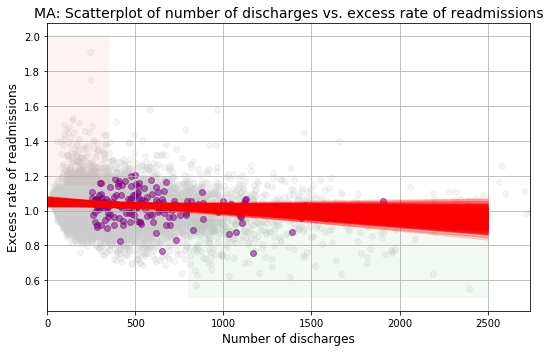

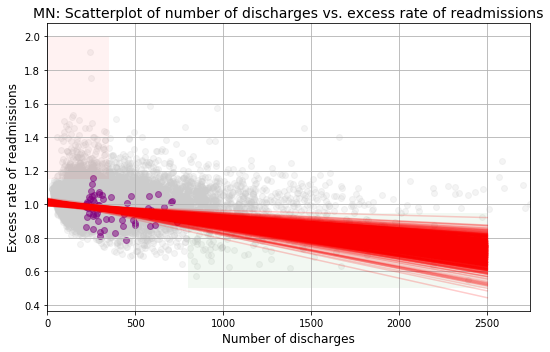

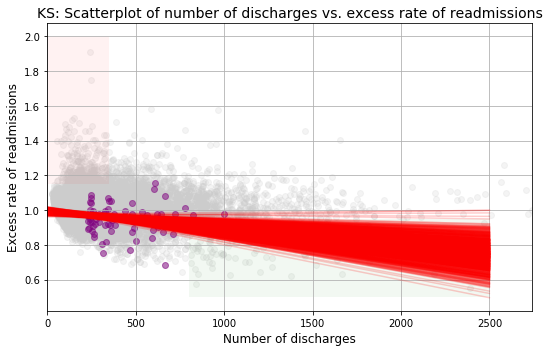

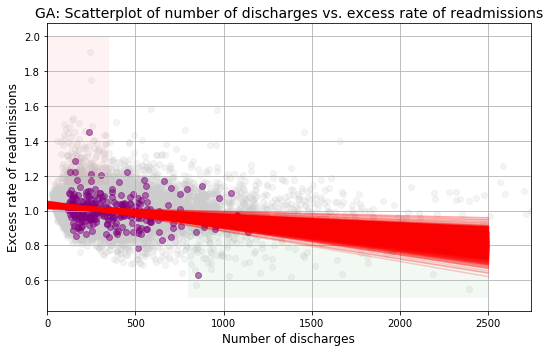

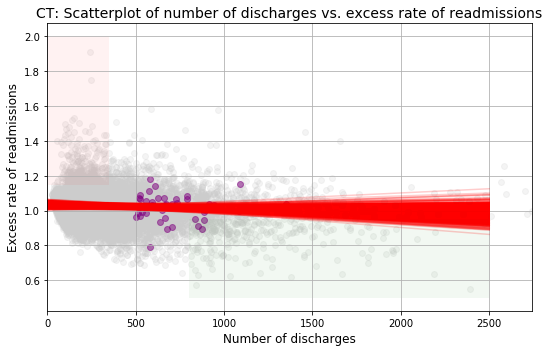

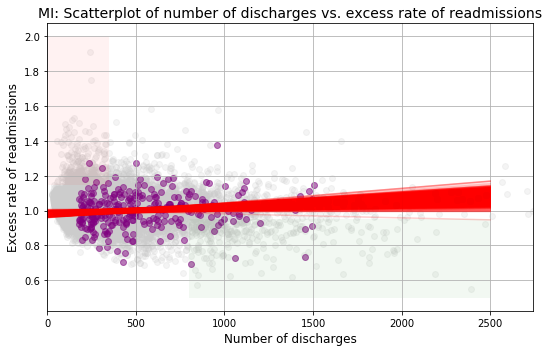

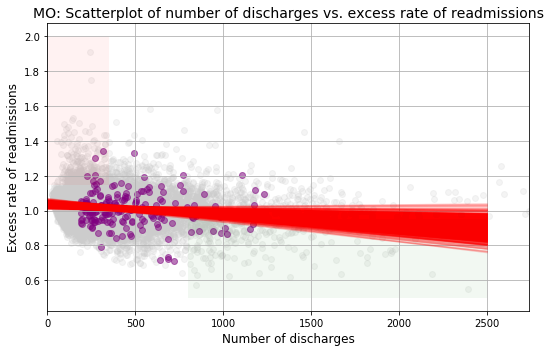

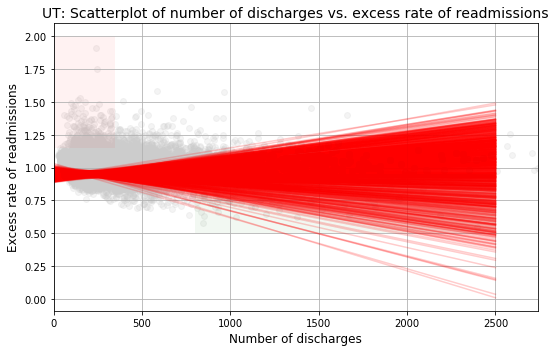

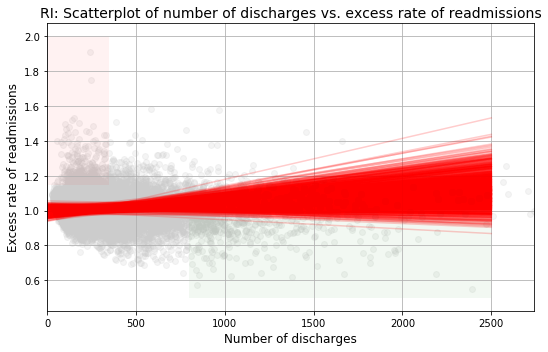

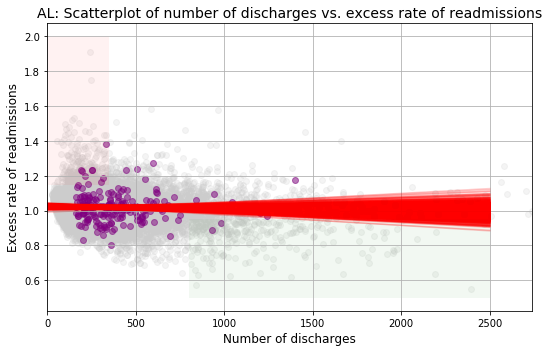

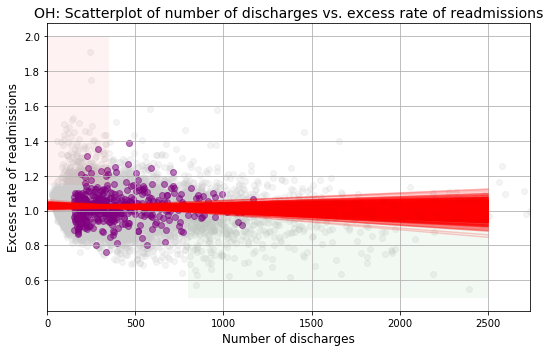

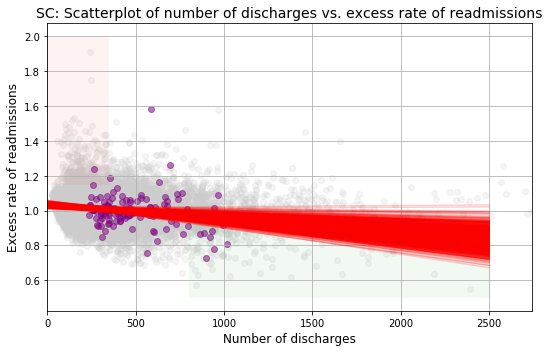

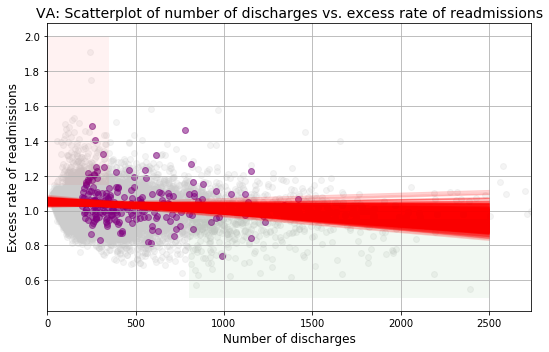

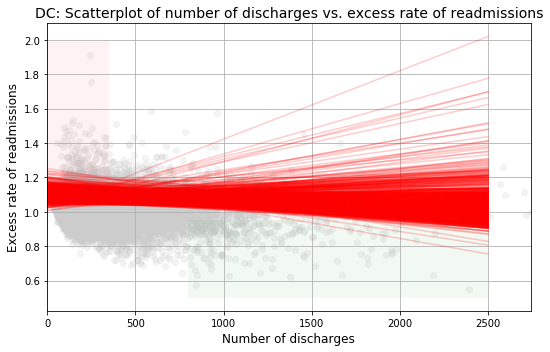

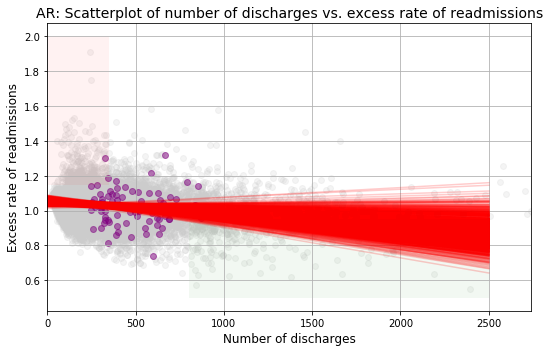

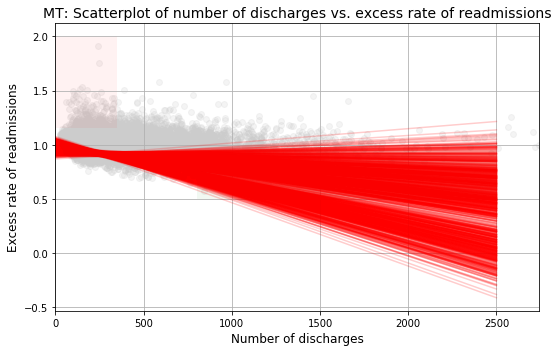

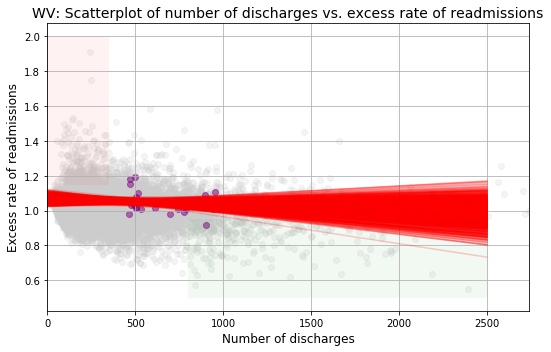

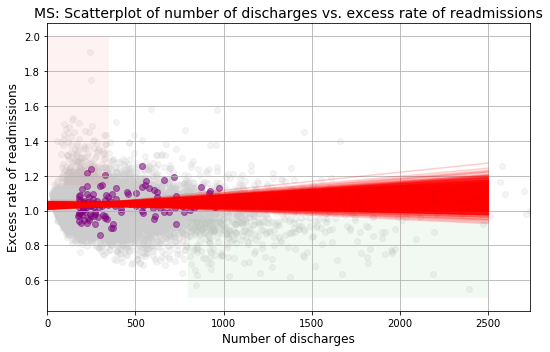

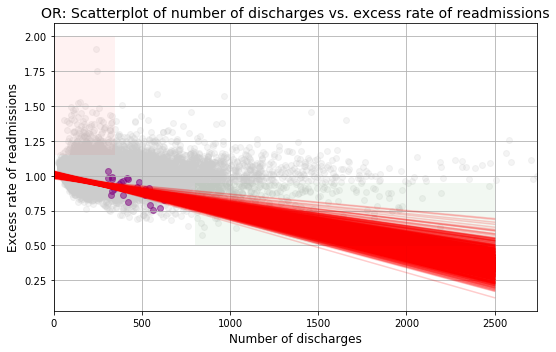

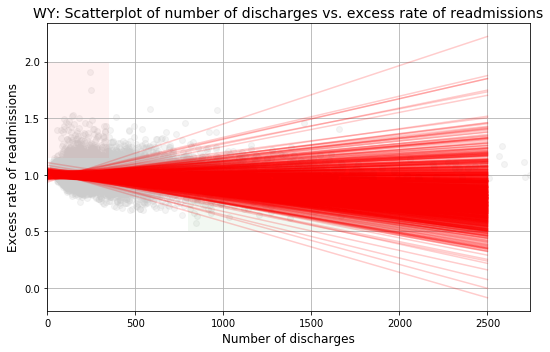

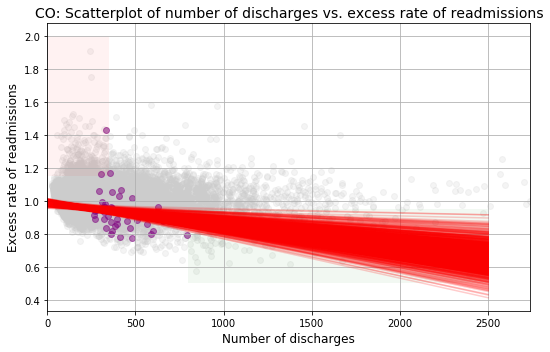

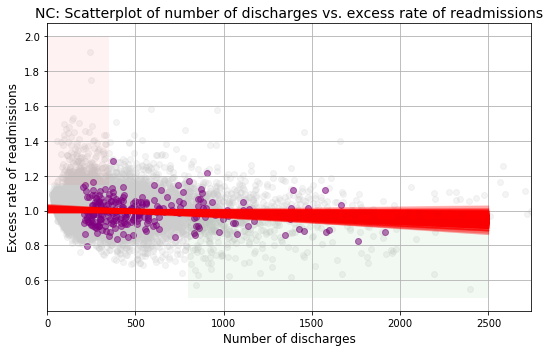

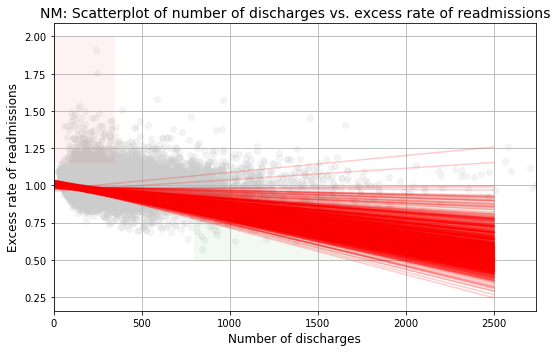

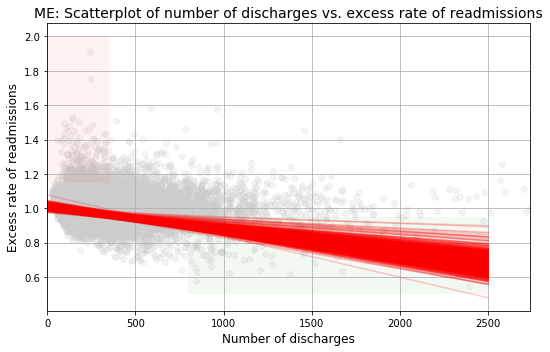

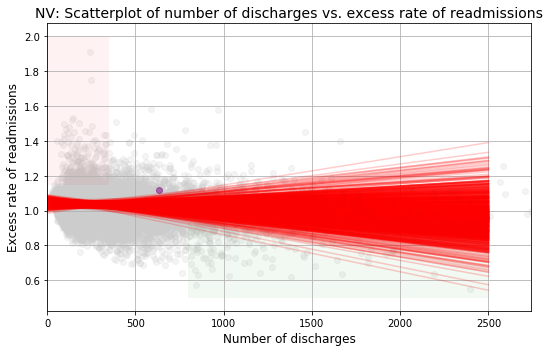

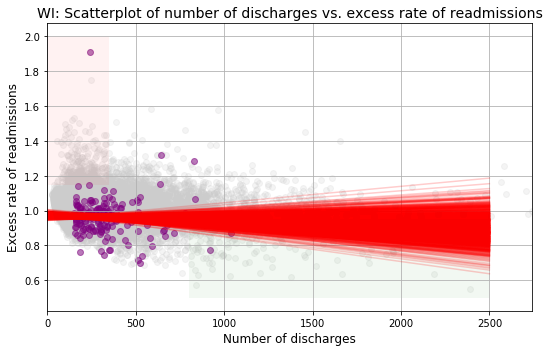

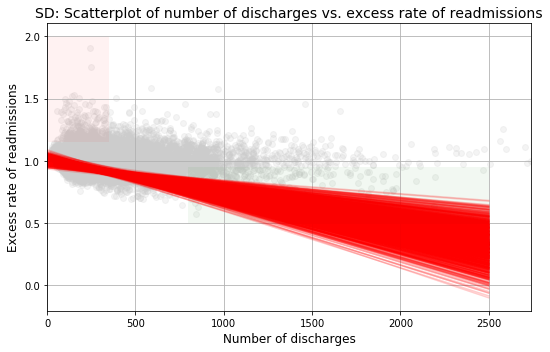

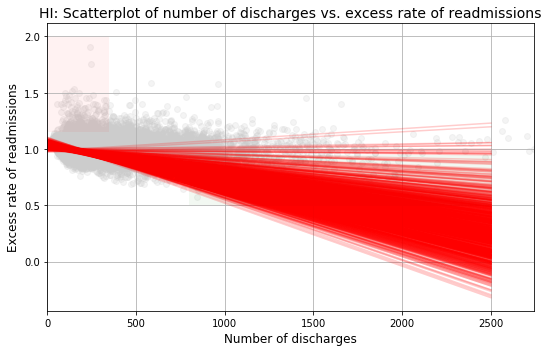

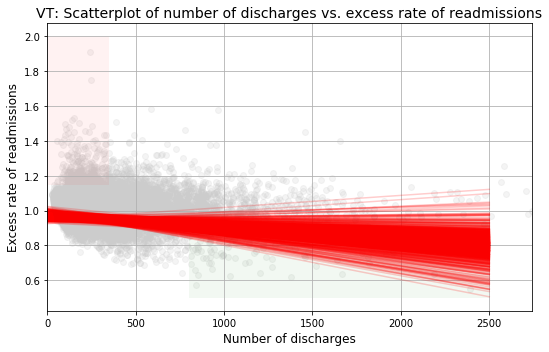

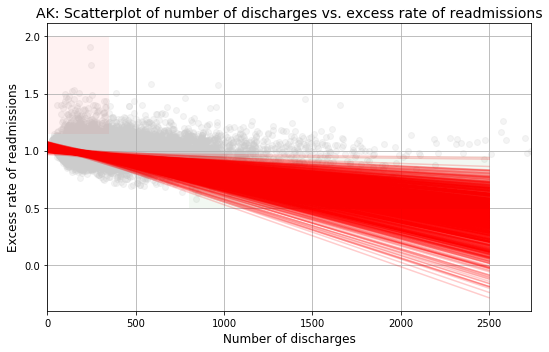

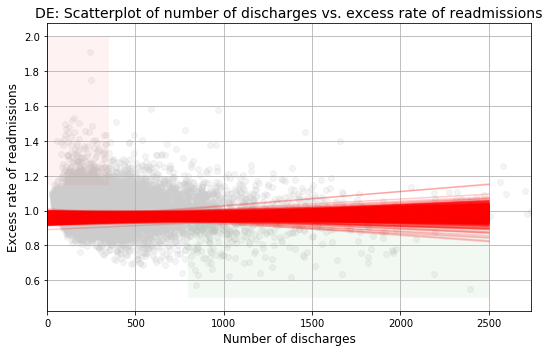

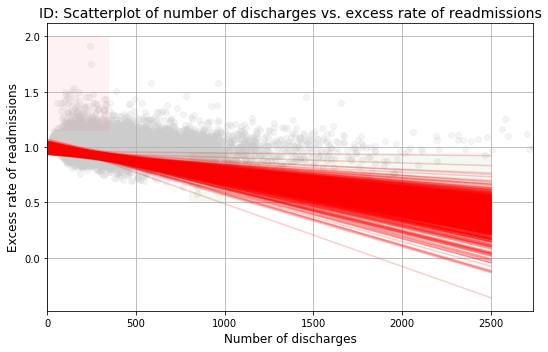

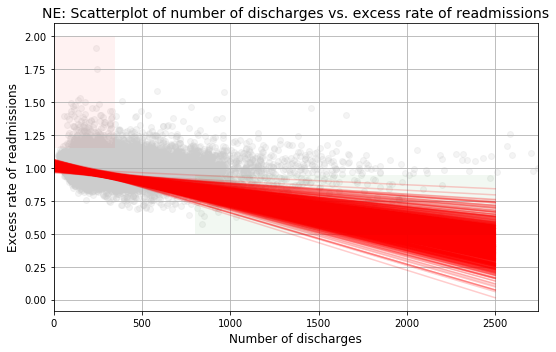

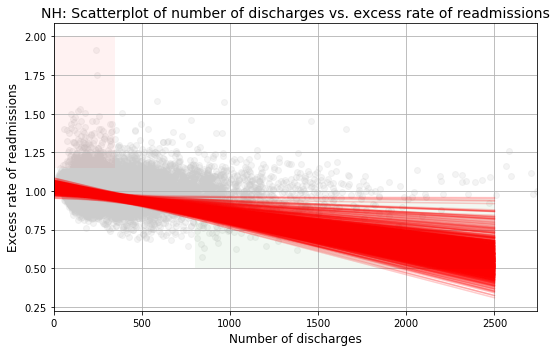

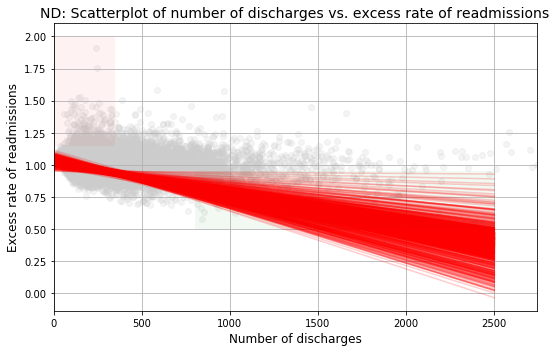

In [89]:
# get unique states for categorization
states = df['State'].unique()

# run linear regression for each
for state in states:
    num_discharges_state = df['Number of Discharges'][df['State'] == state]
    num_discharges_state = num_discharges_state.reset_index()
    num_discharges_state = num_discharges_state['Number of Discharges']
#    print(num_discharges_state)
    read_ratio_state = df['Excess Readmission Ratio'][df['State'] == state]
    read_ratio_state = read_ratio_state.reset_index()
    read_ratio_state = read_ratio_state['Excess Readmission Ratio']
#    print(read_ratio_state)

    # create replicates
    read_replicates_slope, read_replicates_intercept = draw_bs_linear_reg(num_discharges_state, read_ratio_state, 1000)

    # plot original scatterplot
    x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
    y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])
    
    # plot the state-specific scatter, in purple
    w = [a for a in clean_hospital_read_df['Number of Discharges'][clean_hospital_read_df['State'] == state][81:-3]]
    z = list(clean_hospital_read_df['Excess Readmission Ratio'][clean_hospital_read_df['State'] == state][81:-3])
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.scatter(x, y,alpha=0.2, color='0.8')
    ax.scatter(w, z,alpha=0.5, color='purple')

    ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .05, interpolate=True)
    ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .05, interpolate=True)

    ax.set_xlim([0, max(x)])
    ax.set_xlabel('Number of discharges', fontsize=12)
    ax.set_ylabel('Excess rate of readmissions', fontsize=12)
    ax.set_title('{}: Scatterplot of number of discharges vs. excess rate of readmissions'.format(state), fontsize=14)

    ax.grid(True)
    fig.tight_layout()
    
    # Plot the bootstrap lines
    for i in range(1000):
        plt.plot(a, (a * read_replicates_slope[i]) + read_replicates_intercept[i], color='red', alpha=0.2)
    
    plt.show()
    

##### Conclusion

These plots convey the information in a more direct manner by breaking the trend down to a state-by-state basis. We do not get lost in the large sample of data, which is now greyscaled, nor are we distracted by the rectangular guides, which are tinted to be more transparent.

By overlaying state-specific data points (purple) we see just how relevant the trend is. For example, states such as WY, MT, DC, RI, and UT have too little data to make meaningful sense of the relationship between discharges and readmissions in their respective areas.

Furthermore, by adding the red bootstrapped linear regression lines, we see how strong the relationship is, and how much it changes from state-to-state. For example, small hospitals in NY, MI and MS outperform large hospitals in terms of readmission. This implies the trend is not universal across all states or regions.

In a revised recommendation to the client, we recommend action on a state-by-state basis. If a state follows the null hypothesis (larger hospitals perform better), then they must monitor small hospitals as the original analysis recommended. If a state shows no trend (level performance across hospital sizes) then we recommend closer monitoring across the entire system, especially for larger hospitals which should be performing better than their smaller adversaries. Finally, if small hospitals are outperforming large hospitals, this reveals a potentially serious problem with the quality of care at that state's larger hospital operations.